In [1]:
pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 8.1 MB/s eta 0:00:00


Streaming output truncated to the last 5000 lines.
New Position: (9.206779172716692, 9.571508350044208), Reward: -33.7
Distance to Hole: 5.561010480599954
Action taken: Angle 37, Power 6
New Position: (9.206779172716692, 9.571508350044208), Reward: -33.800000000000004
Distance to Hole: 5.561010480599954
Action taken: Angle 37, Power 6
New Position: (9.206779172716692, 9.571508350044208), Reward: -33.9
Distance to Hole: 5.561010480599954
Action taken: Angle 37, Power 6
New Position: (9.206779172716692, 9.571508350044208), Reward: -34.0
Distance to Hole: 5.561010480599954
Action taken: Angle 37, Power 6
New Position: (9.206779172716692, 9.571508350044208), Reward: -34.1
Distance to Hole: 5.561010480599954
Action taken: Angle 37, Power 6
New Position: (9.206779172716692, 9.571508350044208), Reward: -34.2
Distance to Hole: 5.561010480599954
Action taken: Angle 37, Power 6
New Position: (9.206779172716692, 9.571508350044208), Reward: -34.300000000000004
Distance to Hole: 5.561010480599954
A

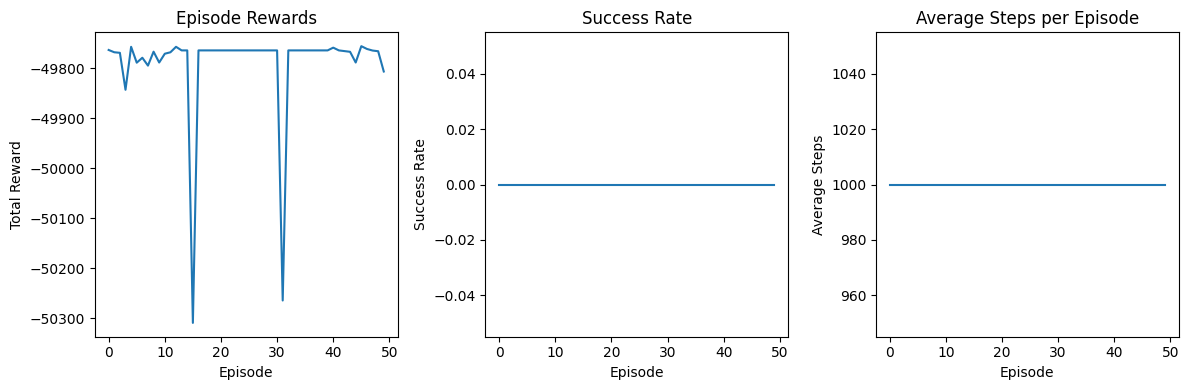

In [8]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import math
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import collections
import matplotlib.pyplot as plt

# Hyperparameters
learning_rate = 0.0005
gamma = 0.98
buffer_limit = 5000
batch_size = 32

class GolfCourseEnv(gym.Env):
    # Course elements
    FAIRWAY = 0  # Fairway
    BUNKER = 1   # Bunker
    WATER = 2    # Water
    HOLE = 3     # Hole
    START = 4    # Starting point

    def __init__(self, course_width=20, course_height=10, num_bunkers=3, num_water_hazards=2, hazard_size=2):
        # Initializing course properties
        self.course_width = course_width
        self.course_height = course_height
        self.num_bunkers = num_bunkers
        self.num_water_hazards = num_water_hazards
        self.hazard_size = hazard_size

        # Range for angles and power for actions
        self.num_angle_actions = 34  # Range from 23° to 56°
        self.num_power_actions = 10  # Power levels from 1 to 10
        self.action_space = spaces.Discrete(self.num_angle_actions * self.num_power_actions)

        # Setting the size of state and action
        self.state_size = 3
        self.action_size = self.num_angle_actions * self.num_power_actions

        # Defining the observation space
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(6,), dtype=np.float32)

        self.reset()

    def reset(self):
        # Initialize the golf course
        self.course = self._create_course()
        self.ball_position = [0, 2]
        self.hole_position = [8, 15]
        self.shot_count = 0
        return self._get_state()

    def step(self, action):
        # Process the action and calculate new state
        angle, power = self._convert_action(action)
        new_position = self._calculate_shot_result(self.ball_position, angle, power)
        reward = self._calculate_reward(new_position)

        # Calculate the distance to the hole
        hole_distance = np.linalg.norm(np.array(self.hole_position) - np.array(new_position))
        done = hole_distance < 0.1

        #print(f"Hole distance: hole position {hole_distance}")
        print(f"Action taken: Angle {angle}, Power {power}")
        print(f"New Position: {new_position}, Reward: {reward}")
        print(f"Distance to Hole: {hole_distance}")
        self.ball_position = new_position
        self.shot_count += 1
        return self._get_state(), reward, done, {}

    def _create_course(self):
        # Initialize the golf course with reduced hazards
        self.num_bunkers = 2  # Reduced number of bunkers
        self.num_water_hazards = 1  # Reduced number of water hazards

        course = np.zeros((self.course_height, self.course_width))
        course = self._place_hazards(course, self.BUNKER, self.num_bunkers, self.hazard_size)
        course = self._place_hazards(course, self.WATER, self.num_water_hazards, self.hazard_size)
        course[8, 15] = self.HOLE
        course[0, 2] = self.START
        print(course)
        return course

    def _place_hazards(self, course, hazard_type, num_hazards, hazard_size):
        # Randomly place hazards on the course
        for _ in range(num_hazards):
            row = random.randint(0, course.shape[0] - hazard_size)
            col = random.randint(0, course.shape[1] - hazard_size)
            course[row:row+hazard_size, col:col+hazard_size] = hazard_type
        return course

    def _get_state(self):
        # Return the current state
        return [
            self.ball_position[0],
            self.ball_position[1],
            self.calculate_distance_to_hole()
        ]

    def _convert_action(self, action):
        # Convert action number to angle and power
        angle_action = action % self.num_angle_actions
        power_action = action // self.num_angle_actions

        angle = 23 + angle_action  # Start from 23 degrees
        power = 1 + power_action   # Start from power level 1
        return angle, power

    def _calculate_shot_result(self, position, angle, power):
        # Calculate the result of the shot
        radian_angle = math.radians(angle)
        delta_x = math.cos(radian_angle) * power
        delta_y = math.sin(radian_angle) * power
        new_position = (position[0] + delta_x, position[1] + delta_y)

        if 0 <= new_position[0] < self.course_width and 0 <= new_position[1] < self.course_height:
            return new_position
        else:
            return position  # If the new position is outside the course, keep the same position

    def _calculate_reward(self, new_position):
        # Calculate the reward
        distance_before = np.linalg.norm(np.array(self.hole_position) - np.array(self.ball_position))
        distance_after = np.linalg.norm(np.array(self.hole_position) - np.array(new_position))
        #reward_distance = max(0, distance_before - distance_after)
        reward_distance = (distance_before - distance_after) * 19

        # Penalty for landing in hazards
        reward_hazard = 0
        #if 0 <= int(new_position[1]) < self.course.shape[0] and 0 <= int(new_position[0]) < self.course.shape[1]:
        #    if self.course[int(new_position[1]), int(new_position[0])] in [self.BUNKER, self.WATER]:
        #        reward_hazard = -2
        if self.course[int(new_position[1]), int(new_position[0])] in [self.BUNKER, self.WATER]:
          reward_hazard = -0.5

        # Reward based on the number of shots taken
        reward_shot_count = -0.1 * self.shot_count
        total_reward = reward_distance + reward_hazard + reward_shot_count
        #total_reward = reward_distance + reward_hazard
        return total_reward

    def calculate_distance_to_hole(self):
       # Calculate the distance to the hole
       return np.linalg.norm(np.array(self.hole_position) - np.array(self.ball_position))


# Define the Qnet class
class Qnet(nn.Module):
    def __init__(self, state_size, action_size):
        # Neural network layers
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)
        self.action_size = action_size

    def forward(self, x):
        # Forward pass through the network
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

    def sample_action(self, obs, epsilon):
        # Sample an action based on the observation
        out = self.forward(obs)
        if random.random() < epsilon:
            return random.randint(0, self.action_size - 1)
        else:
            return out.argmax().item()

# Define the ReplayBuffer class
class ReplayBuffer():
    def __init__(self):
        # Initialize the replay buffer
        self.buffer = collections.deque(maxlen=buffer_limit)

    def put(self, transition):
        # Add a transition to the buffer
        self.buffer.append(transition)

    def sample(self, n):
        # Sample a mini-batch from the buffer
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst, dtype=torch.long), \
               torch.tensor(r_lst, dtype=torch.float), torch.tensor(s_prime_lst, dtype=torch.float), \
               torch.tensor(done_mask_lst, dtype=torch.float)

    def size(self):
        # Get the size of the buffer
        return len(self.buffer)

# Define the train function
def train(q, q_target, memory, optimizer):
    # Training loop
    for i in range(10):
        s, a, r, s_prime, done_mask = memory.sample(batch_size)

        q_out = q(s)
        q_a = q_out.gather(1, a)
        #max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
        argmax_Q = q(s_prime).max(1)[1].unsqueeze(1)
        max_q_prime = q_target(s_prime).gather(1,argmax_Q)
        target = r + gamma * max_q_prime * done_mask
        #loss = F.smooth_l1_loss(q_a, target)
        loss = F.mse_loss(q_a,target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def main():
    rewards = []
    success_rates = []
    average_steps = []
    # Initialize the environment and agent
    env = GolfCourseEnv()
    q = Qnet(env.state_size, env.action_size)
    q_target = Qnet(env.state_size, env.action_size)
    q_target.load_state_dict(q.state_dict())
    memory = ReplayBuffer()
    optimizer = optim.Adam(q.parameters(), lr=learning_rate)

    print_interval = 5

    # Training loop
    for episode in range(50):
        epsilon = max(0.01, 0.08 - 0.01 * (episode / 200))  # Initialize epsilon
        state = env.reset()
        done = False
        episode_reward = 0
        episode_steps = 0
        success = False

        while not done:
            episode_steps += 1
            state_tensor = torch.from_numpy(np.array(state, dtype=np.float32))
            action = q.sample_action(state_tensor, epsilon)
            next_state, reward, done, _ = env.step(action)
            memory.put((state, action, reward, next_state, done))
            state = next_state
            episode_reward += reward

            if done:
                success = True

            if memory.size() > 1000:
                train(q, q_target, memory, optimizer)

            if episode_steps >= 1000:
                done = True

        print(f"Episode {episode} - Total Reward: {episode_reward}, Total Steps: {episode_steps}")
        rewards.append(episode_reward)
        success_rates.append(1 if success else 0)
        average_steps.append(episode_steps)

        if episode % print_interval == 0 and episode != 0:
            q_target.load_state_dict(q.state_dict())

    # Plotting the graphs
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(rewards)
    plt.title('Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')

    plt.subplot(1, 3, 2)
    plt.plot(success_rates)
    plt.title('Success Rate')
    plt.xlabel('Episode')
    plt.ylabel('Success Rate')

    plt.subplot(1, 3, 3)
    plt.plot(average_steps)
    plt.title('Average Steps per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Average Steps')

    plt.tight_layout()
    plt.show()
    env.close()

if __name__ == '__main__':
    main()
